# Simple MCMC Chain

##### This notebook is a simple jumpstart into MCMC Chains which can be used for estimating parameters of a simple linear regression model. For the full tutorial and to learn how to estimate more than 2 parameters, look at the full tutorial at -
Link

These are imported modules, meaning we are using code and functionality that is not coded in this The import statement is the most common way of invoking the import machinery. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.optimize import minimize
import threading
import random

Suppose we have a line $y = mx + b$, we are estimating the slope of the line $m$ as $/alpha$ and the intercept of the y -axis $b$ as $beta$. Let's make this line with the parameters below. The list $time$ is the number of data-points.

In [2]:
alpha_true = -2
beta_true = -5
time = list(range(1,11))
y_true = [alpha_true*time[i] + beta_true for i in range(0,10)]
sigma = 1
meas_err = np.random.normal(loc = 0, scale = sigma, size = len(time))
y = y_true + meas_err #Adding some noise to the line. 

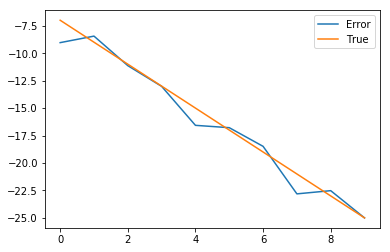

In [3]:
plt.plot(y,label='Error')
plt.plot(y_true,label='True')
plt.legend()
plt.show()

Functions that we need

In [4]:
def logp(theta, y, sigma=1):
    N = len(y)
    alpha, beta = theta[0], theta[1]
    model = [alpha * time[i] + beta for i in range(0, 10)]
    resid = y - model
    log_likelihood = -N / 2 * math.log(
        2 * math.pi) - N * math.log(sigma) - 1 / 2 * sum(resid**2) / sigma**2
    log_prior = 0  # log(1)
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [5]:
def MCMC_chains(y, N = 30000, isPlot = False):
    alpha_init = np.random.randint(-50,50)
    beta_init = np.random.randint(-50,50)
    theta = [alpha_init,beta_init]
    time = len(y)
    lp = logp(theta,y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    step = [.1, 1]
    for i in range(N):
        theta_new = list(stats.norm.rvs(theta, step))
        lp_new = logp(theta_new, y)
        lq = lp_new - lp
        lr = math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    print('Acceptance Rate',accepts/N*100)
    mcmc_chains = np.array(mcmc_chains)
    if isPlot:
        plt.figure(figsize=(16, 4))
        plt.plot(mcmc_chains[:, 0], linewidth=0.25, label='Alpha')
        plt.plot(mcmc_chains[:, 1], linewidth=0.25, label='Beta')
        plt.title('History Plot')
        plt.legend()
        plt.show()
        alpha = mcmc_chains[:,0]
        beta = mcmc_chains[:,1]
    return mcmc_chains

Lets call the function using 3 parameters -
1. Our sampled data set
2. The number of iteration we want our chain to be
3. If we want a history plot or not showing the sampled alpha and beta values.

We want our acceptance rate to be above 23% and below 44%. For the reasoning, look at the full tutorial.$$$$
This is where you would change y and put in your data. Any alpha and beta estimate will represent a line.

Acceptance Rate 28.39333333333333


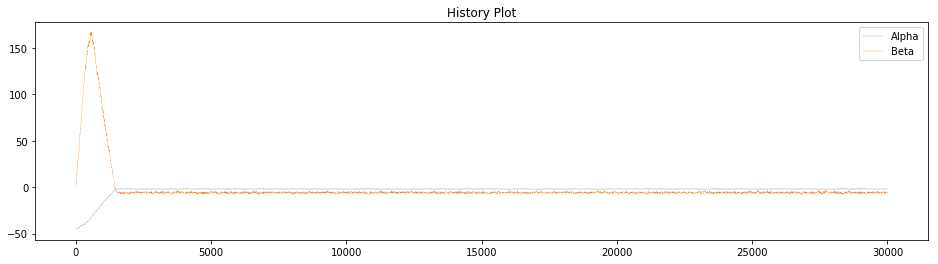

In [6]:
mcmc_chains = MCMC_chains(y, 30000, True)

Our acceptance rate is between the desired range. Looks good so far!

Now lets look at how to thin our values and take only those estimates which are necessary to estimate our alpha and beta. We could take the whole chain after the burn-in and take an average, but for longer chains, it makes computational sense to thin our values so that are estimates are relatively independent.

In [12]:
def plot_correlation(mcmc_chains):
    alpha = mcmc_chains[:,0]
    beta = mcmc_chains[:,1]
    cora, ra, flaga = [], None, True
    corb, rb, flagb = [], None, True
    for lag in range(1, 5000):
        Xa,Xb = alpha[:len(alpha) - lag], beta[:len(beta) - lag]
        Ya,Yb = alpha[lag:], beta[lag:]
        cora.append(np.corrcoef(Xa, Ya, rowvar=False)[0][1])
        corb.append(np.corrcoef(Xb, Yb, rowvar=False)[0][1])
        if flaga and cora[lag - 1] <= 0.05:
            flaga = False
            ra = lag
        if flagb and corb[lag - 1] <= 0.05:
            flagb = False
            rb = lag
    plt.plot(range(1, len(cora)+1), cora, label = 'alpha')
    plt.plot([ra, ra], [-0.2, 1], label='alpha lag')
    plt.plot(range(1, len(corb)+1), corb, label = 'beta')
    plt.plot([rb, rb], [-0.2, 1], label='beta lag')
    title = 'Correlation'
    plt.title(title)
    plt.legend()
    plt.xlabel('Gap between elements')
    plt.ylabel('Correlation')
    plt.show()
    return ra if ra > rb else eb

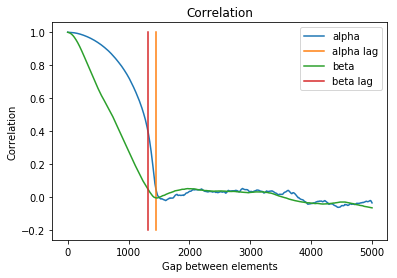

Alpha estimate -4.0407942338085645
Beta estimate -5.302291321202704


In [13]:
jump = plot_correlation(mcmc_chains)
alpha1, beta1 = [], []
for i in range(0, len(mcmc_chains), jump):
    alpha1.append(mcmc_chains[i][0])
    beta1.append(mcmc_chains[i][1])
print('Alpha estimate', np.mean(alpha1))
print('Beta estimate', np.mean(beta1))

Looking at our correlation function, we see that at about  1200 values apart, the values are not correlated. The reason the 'lag' is so high is because we have not cut-off our burn-in.

## Gelman-Rubin convergence diagnostic

This will help us determine when our chain has burnt-in by comparing variances between and inside multiple chains (more than 2)

Acceptance Rate 27.73333333333333
Acceptance Rate 28.633333333333333
Acceptance Rate 28.683333333333334
Acceptance Rate 27.65666666666667
Acceptance Rate 27.41
Acceptance Rate 28.196666666666665
Acceptance Rate 27.913333333333334
Acceptance Rate 27.49666666666667
Acceptance Rate 28.333333333333332
Acceptance Rate 27.913333333333334


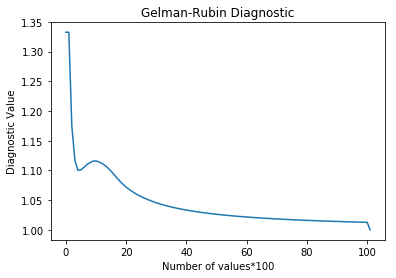

In [14]:
mcmc_chains = []
N = 30000
m = 10
for i in range(m):
    mcmc_chains.append(MCMC_chains(y, N))
mcmc_chains = np.array(mcmc_chains)

def diagnsotic(mcmc_chains):
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = N / (m - 1) * np.sum([(np.mean(mcmc_chains[i]) - global_mean)**2
                              for i in range(m)])
    Var = (1 - 1/N)*W + 1/N*B
    return np.sqrt(Var/W)

R = [(diagnsotic(mcmc_chains[:,0,:]))]
burn_in = 1
while burn_in < 10000:
    R.append(diagnsotic(mcmc_chains[:,:burn_in,:]))
    burn_in += 100
R.append(diagnsotic(mcmc_chains[:,burn_in:,:]))

plt.plot(R)
plt.title('Gelman-Rubin Diagnostic')
plt.xlabel('Number of values*100')
plt.ylabel('Diagnostic Value')
plt.show()

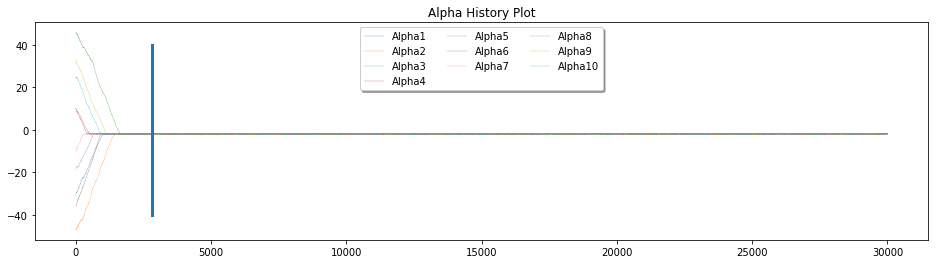

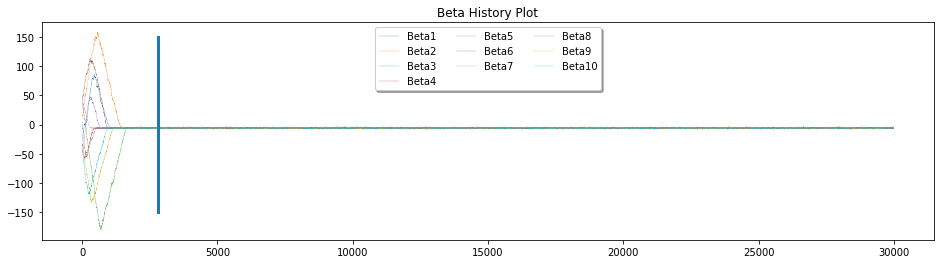

In [20]:
for i in R:
    if i < 1.05: 
        burn_in = R.index(i)*100
        break
plt.figure(figsize=(16, 4))
for i in range(len(mcmc_chains)):
    plt.plot(mcmc_chains[i,:,0], linewidth=0.25, label='Alpha'+str(i+1))
plt.plot([burn_in,burn_in],[-40,40], linewidth=3)
plt.title('Alpha History Plot')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)
plt.figure(figsize=(16, 4))
for i in range(len(mcmc_chains)):
    plt.plot(mcmc_chains[i,:,1], linewidth=0.25, label='Beta'+str(i+1))
plt.plot([burn_in,burn_in],[-150,150], linewidth=3)
plt.title('Beta History Plot')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)
plt.show()

The variable ```burn-in``` stores the number of value at which our chains have burnt-in.

In [66]:
alpha_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),jump):
        alpha_hist.append(mcmc_chains[i,j,0])
beta_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),jump):
        beta_hist.append(mcmc_chains[i,j,1])
alpha_CI = [np.percentile(alpha_hist, 5),np.percentile(alpha_hist, 95)]
beta_CI = [np.percentile(beta_hist, 5),np.percentile(beta_hist, 95)]
print(alpha_CI)
print(beta_CI)

[-2.1543349872439803, -1.7760711390122197]
[-6.034827160521897, -3.714555060915485]


This is our 95% credible interval for our alpha and beta estimate. This means that 95% of the time, our sampled mean for alpha and beta will fall in this range.